In [1]:
import utils
import random
random.seed(42)
questoes = utils.load_json("./questoes/questoes.json")

In [2]:
text_questions = list(filter(lambda x : x["type"] == "only-text", questoes))
text_models = ["phi4", "llava", "deepseek-r1", "llama3.2", "gemma2", "mistral"]
df_text_questions = utils.test_table(questions=text_questions,models=text_models)
df_text_questions

,Model,Finish,OK,Null,Err,Tout,Acc,Ttot,Tle,Tavg,Tmax,Tmin
0,phi4,1608,1338,12,258,0,0.832090,10422.020824,0.000000,6.481356,106.759996,0.320840
1,gemma2,1608,1208,30,370,0,0.751244,999.547631,0.000000,0.621609,11.382335,0.271672
2,mistral,1608,931,30,647,0,0.578980,1477.893429,0.000000,0.919088,20.847775,0.169479
3,deepseek-r1,1608,884,126,598,0,0.549751,32629.789706,0.000000,20.292158,469.823419,2.529047
4,llava,1608,731,77,800,0,0.454602,913.413975,0.000000,0.568044,10.902573,0.151764
5,llama3.2,1608,426,28,1154,0,0.264925,530.821205,0.000000,0.330113,41.733469,0.086080
6,TOTAL,9648,5518,303,3827,0,0.571932,46973.486770,-39144.572309,4.868728,469.823419,0.086080


In [3]:
context_questions = list(filter(lambda x : x["type"] == "context-image", questoes))

example_context_questions = (
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-humanas", context_questions)), 25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-natureza", context_questions)),25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "linguagens", context_questions)),25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "matematica", context_questions)),25))[:10]
)

models_vision =  ["llava", "llama3.2-vision", "llava-llama3", "minicpm-v","moondream", "llava-phi3"]
best_text_models = ["mistral", "gemma2", "phi4"]

df_multi_models = utils.test_table(
    questions=example_context_questions,
    models=utils.gen_modelos_str(primary_models=best_text_models, secundary_models=models_vision)
)
df_multi_models


,Model,Finish,OK,Null,Err,Tout,Acc,Ttot,Tle,Tavg,Tmax,Tmin
0,minicpm-v+phi4,40,27,0,13,0,0.675000,906.579981,0.000000,22.664500,40.362884,9.492539
1,llama3.2-vision+phi4,40,24,0,16,0,0.600000,1409.801672,0.000000,35.245042,55.777335,11.767686
2,minicpm-v+gemma2,40,22,1,17,0,0.550000,447.025448,0.000000,11.175636,23.790783,7.859171
3,moondream+phi4,40,22,0,18,0,0.550000,658.142070,0.000000,16.453552,31.810091,8.576085
4,moondream+gemma2,40,21,1,18,0,0.525000,250.860796,0.000000,6.271520,11.623579,4.953213
5,llava+phi4,40,21,0,19,0,0.525000,713.577472,0.000000,17.839437,38.276308,8.344454
6,llava-llama3+phi4,40,21,0,19,0,0.525000,808.986937,0.000000,20.224673,58.207987,9.691348
7,llava+gemma2,40,20,1,19,0,0.500000,339.000211,0.000000,8.475005,14.254210,5.866373
8,llava-phi3+phi4,40,20,0,20,0,0.500000,667.504456,0.000000,16.687611,35.885895,8.591724
9,llava-phi3+gemma2,40,19,0,21,0,0.475000,338.563672,0.000000,8.464092,13.888252,5.487619


C:\Users\ruben\AppData\Local\Temp\ipykernel_21808\1297961828.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


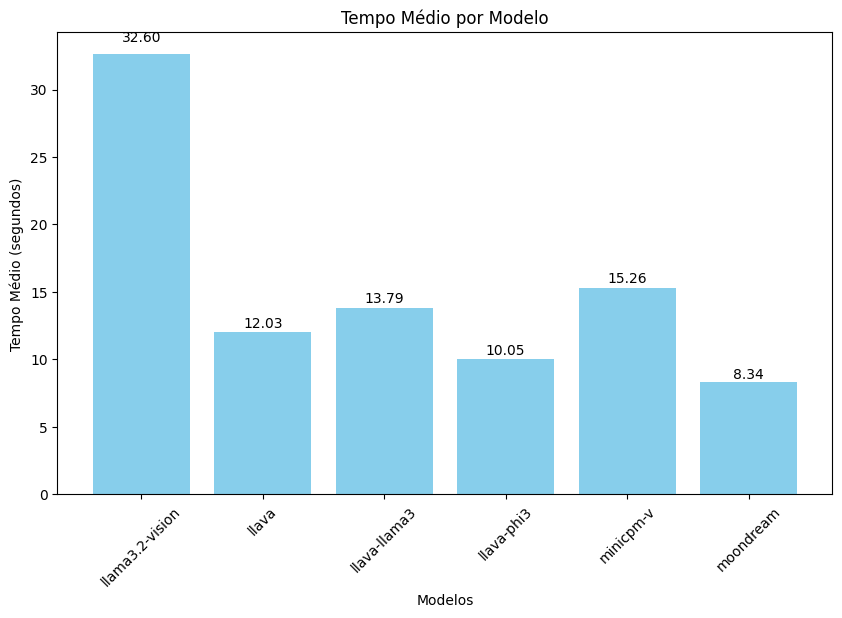

In [4]:
from utils import plots
import pandas as pd

plots.multi_model_performance(
    'model_vision', 'time-avg',context_questions,
    vision_models=models_vision, text_models=best_text_models
).show()
